In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint



2025-01-05 23:52:09.700009: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-05 23:52:09.747732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736117529.818460 1624661 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736117529.831800 1624661 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 23:52:09.857282: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Define the file paths
subdirectory = "pickle_data_Konditorei"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
#test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
#print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())


Loaded Training features dimensions: (1766, 31)
Loaded Validation features dimensions: (0, 31)
Loaded Test features dimensions: (354, 31)

Loaded Training labels dimensions: (1766, 1)
Loaded Validation labels dimensions: (0, 1)

First few rows of loaded training features:
      Temp_Cold_current  Temp_Warm_current  Temp_Hot_current  \
5457                  0                  0                 0   
5458                  0                  0                 0   
5459                  0                  1                 0   
5460                  0                  0                 0   
5461                  0                  0                 0   

      Cloud_ok_current  Cloud_Cloudy_current  KielerWoche_current  \
5457                 0                     1                    0   
5458                 1                     0                    0   
5459                 0                     1                    0   
5460                 0                     1                    0 

In [3]:
#Defining the Neural Network

model = Sequential([
    InputLayer(shape=(training_features.shape[1], )),
    Dropout(0.2),
    Dense(50, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.1)),
    # Dropout(0.2),
    Dense(25, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.1)),

    Dense(1)
])

model.summary()

I0000 00:00:1736117531.530153 1624661 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,901 (11.33 KB)

 Trainable params: 2,901 (11.33 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:

# SGD with optimized parameters
optimizer = SGD(
    #learning_rate=0.001, gesteuert durch den lr_scheduler
    momentum=0.9,    # Add momentum to help escape local minima
    nesterov=True,   # Use Nesterov momentum for better convergence
)

model.compile(
    loss="huber",    # More robust to outliers
    optimizer=optimizer,
    metrics=['mape']
)

# Custom learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.0001
    drop = 0.5
    epochs_drop = 50.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return max(lr, 1e-5)  # Don't let LR get too small

history = model.fit(
    training_features, 
    training_labels, 
    epochs=200,
    batch_size=16,   # Smaller batch size works better with SGD
    verbose=1,
    validation_data=(validation_features, validation_labels),
    callbacks=[
        EarlyStopping(
            monitor='mape',
            patience=20,
            restore_best_weights=True,
            mode='min'
        ),
        LearningRateScheduler(lr_schedule),
        ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
)

Epoch 1/200


I0000 00:00:1736117543.208064 1624747 service.cc:148] XLA service 0x7f3ef0008060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736117543.208108 1624747 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-05 23:52:23.228344: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736117543.290288 1624747 cuda_dnn.cc:529] Loaded cuDNN version 90300


 27/111 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101.3960 - mape: 99.9363

I0000 00:00:1736117544.676892 1624747 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 101.6102 - mape: 99.7427 - learning_rate: 1.0000e-04
Epoch 2/200
 28/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.8898 - mape: 98.7937

/home/nolnmarten/workspace/code/machinelearning/bakery_sales_prediction/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-01-05 23:52:24.810830: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-05 23:52:24.810882: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:52:24.810891: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:24.810908: I tensorflow/co

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 99.9951 - mape: 98.5407 - learning_rate: 1.0000e-04
Epoch 3/200
 30/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 98.0502 - mape: 97.2694

2025-01-05 23:52:25.329957: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:52:25.330003: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:25.330025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 98.5492 - mape: 96.8702 - learning_rate: 1.0000e-04
Epoch 4/200
 80/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.7481 - mape: 94.2373

2025-01-05 23:52:25.729131: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:25.729181: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.3523 - mape: 93.8786 - learning_rate: 1.0000e-04
Epoch 5/200
 41/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 92.5508 - mape: 88.4673

2025-01-05 23:52:25.995438: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:52:25.995480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:25.995500: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 90.1214 - mape: 86.8641 - learning_rate: 1.0000e-04
Epoch 6/200
 53/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 78.2116 - mape: 71.4608

2025-01-05 23:52:26.458638: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:26.458689: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 73.6077 - mape: 65.7471 - learning_rate: 1.0000e-04
Epoch 7/200
 53/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.6650 - mape: 35.3408

2025-01-05 23:52:26.797104: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:26.797149: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.3681 - mape: 34.1345 - learning_rate: 1.0000e-04
Epoch 8/200
 43/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.6906 - mape: 32.2655

2025-01-05 23:52:27.132605: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:27.132667: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.4973 - mape: 31.4010 - learning_rate: 1.0000e-04
Epoch 9/200
 47/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.6779 - mape: 29.5709

2025-01-05 23:52:27.498092: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:52:27.498130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:27.498148: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.8672 - mape: 29.1400 - learning_rate: 1.0000e-04
Epoch 10/200
 45/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.1324 - mape: 26.8644

2025-01-05 23:52:27.854174: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:27.854248: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.4050 - mape: 27.3129 - learning_rate: 1.0000e-04
Epoch 11/200
 47/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.3311 - mape: 26.2630

2025-01-05 23:52:28.248975: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:28.249018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.6089 - mape: 26.6939 - learning_rate: 1.0000e-04
Epoch 12/200
 48/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.1160 - mape: 28.4048

2025-01-05 23:52:28.609557: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:28.609612: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.1086 - mape: 27.3403 - learning_rate: 1.0000e-04
Epoch 13/200
 42/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.1625 - mape: 24.2096

2025-01-05 23:52:29.040085: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:29.040157: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.8531 - mape: 24.3995 - learning_rate: 1.0000e-04
Epoch 14/200
 44/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.5386 - mape: 24.2024

2025-01-05 23:52:29.512285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:29.512329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.4238 - mape: 24.4741 - learning_rate: 1.0000e-04
Epoch 15/200
 49/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.1646 - mape: 24.3863

2025-01-05 23:52:29.974819: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:29.974864: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 31.3319 - mape: 24.2798 - learning_rate: 1.0000e-04
Epoch 16/200
 29/111 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 32.3583 - mape: 26.1412

2025-01-05 23:52:30.621934: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:30.621981: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.6190 - mape: 24.2999 - learning_rate: 1.0000e-04
Epoch 17/200
 23/111 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.8415 - mape: 23.8343

2025-01-05 23:52:31.102729: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:52:31.102771: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:31.102789: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.5135 - mape: 23.2927 - learning_rate: 1.0000e-04
Epoch 18/200


2025-01-05 23:52:31.544170: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:31.544231: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 28.3759 - mape: 22.9948 - learning_rate: 1.0000e-04
Epoch 19/200
 37/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.8987 - mape: 22.6281

2025-01-05 23:52:32.219749: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:32.219799: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.6356 - mape: 22.3798 - learning_rate: 1.0000e-04
Epoch 20/200
 35/111 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.1221 - mape: 22.6304

2025-01-05 23:52:32.723394: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:32.723440: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.5099 - mape: 22.5123 - learning_rate: 1.0000e-04
Epoch 21/200
 42/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.6305 - mape: 23.6187

2025-01-05 23:52:33.181827: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:33.181901: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 27.9856 - mape: 22.9547 - learning_rate: 1.0000e-04
Epoch 22/200
 40/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.1475 - mape: 20.1059

2025-01-05 23:52:33.715607: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:33.715649: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 25.4605 - mape: 21.1224 - learning_rate: 1.0000e-04
Epoch 23/200
 46/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.0641 - mape: 23.4366

2025-01-05 23:52:34.218532: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:34.218590: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.4283 - mape: 22.8890 - learning_rate: 1.0000e-04
Epoch 24/200
 62/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.8714 - mape: 21.5922

2025-01-05 23:52:34.702163: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:34.702210: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.9195 - mape: 21.6327 - learning_rate: 1.0000e-04
Epoch 25/200
 63/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.0975 - mape: 23.2703

2025-01-05 23:52:35.024673: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:35.024720: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.1538 - mape: 22.7833 - learning_rate: 1.0000e-04
Epoch 26/200
 39/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.3299 - mape: 21.7133

2025-01-05 23:52:35.387324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:35.387370: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.3751 - mape: 21.8828 - learning_rate: 1.0000e-04
Epoch 27/200
 57/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.5176 - mape: 23.6752

2025-01-05 23:52:35.857011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:35.857065: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.7573 - mape: 22.7105 - learning_rate: 1.0000e-04
Epoch 28/200
 19/111 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25.3176 - mape: 20.7322

2025-01-05 23:52:36.206049: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:36.206098: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 25.0425 - mape: 21.7041 - learning_rate: 1.0000e-04
Epoch 29/200
 61/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.6766 - mape: 21.2891

2025-01-05 23:52:36.771764: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:36.771831: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.6484 - mape: 21.3869 - learning_rate: 1.0000e-04
Epoch 30/200
 64/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.7978 - mape: 22.3181

2025-01-05 23:52:37.109336: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:37.109387: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.8662 - mape: 22.3188 - learning_rate: 1.0000e-04
Epoch 31/200
 70/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.2075 - mape: 22.0112

2025-01-05 23:52:37.433973: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:37.434022: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.3319 - mape: 22.1119 - learning_rate: 1.0000e-04
Epoch 32/200
 69/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.2300 - mape: 22.9630

2025-01-05 23:52:37.744345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:37.744410: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.4931 - mape: 22.5903 - learning_rate: 1.0000e-04
Epoch 33/200
 74/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.2035 - mape: 22.3004

2025-01-05 23:52:38.051779: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:52:38.051818: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:38.051836: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.1541 - mape: 22.2433 - learning_rate: 1.0000e-04
Epoch 34/200
 72/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.9893 - mape: 22.7001

2025-01-05 23:52:38.361586: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:38.361639: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.6038 - mape: 22.5095 - learning_rate: 1.0000e-04
Epoch 35/200
 68/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.8598 - mape: 22.8071

2025-01-05 23:52:38.655020: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:38.655075: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.0088 - mape: 22.5716 - learning_rate: 1.0000e-04
Epoch 36/200
 75/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.8895 - mape: 21.3454

2025-01-05 23:52:38.967530: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:38.967588: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.7712 - mape: 21.5143 - learning_rate: 1.0000e-04
Epoch 37/200
 67/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.6207 - mape: 20.7440

2025-01-05 23:52:39.255018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:39.255068: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.9012 - mape: 21.0909 - learning_rate: 1.0000e-04
Epoch 38/200
 65/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.4709 - mape: 21.8890

2025-01-05 23:52:39.585527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:39.585578: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.6833 - mape: 21.6919 - learning_rate: 1.0000e-04
Epoch 39/200
 74/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.1164 - mape: 23.1071

2025-01-05 23:52:39.906764: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:39.906811: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.8723 - mape: 22.7389 - learning_rate: 1.0000e-04
Epoch 40/200
 53/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.9215 - mape: 21.9742

2025-01-05 23:52:40.224851: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:40.224907: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.1050 - mape: 22.1259 - learning_rate: 1.0000e-04
Epoch 41/200
 70/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.2846 - mape: 21.8830

2025-01-05 23:52:40.572451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:40.572527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.1681 - mape: 22.0256 - learning_rate: 1.0000e-04
Epoch 42/200
 73/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.9412 - mape: 22.5501

2025-01-05 23:52:40.875582: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:40.875628: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.8938 - mape: 22.3571 - learning_rate: 1.0000e-04
Epoch 43/200
 69/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.9962 - mape: 21.6203

2025-01-05 23:52:41.171076: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:41.171126: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.2378 - mape: 21.8650 - learning_rate: 1.0000e-04
Epoch 44/200
 58/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.5120 - mape: 22.6310

2025-01-05 23:52:41.483485: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:41.483583: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.4963 - mape: 22.3772 - learning_rate: 1.0000e-04
Epoch 45/200
 61/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.0969 - mape: 22.2412

2025-01-05 23:52:41.899597: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:41.899655: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.2149 - mape: 22.1265 - learning_rate: 1.0000e-04
Epoch 46/200
 63/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.9520 - mape: 23.1091

2025-01-05 23:52:42.266902: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:42.266957: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.7851 - mape: 22.7179 - learning_rate: 1.0000e-04
Epoch 47/200
 67/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.0400 - mape: 21.5331

2025-01-05 23:52:42.657301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:42.657355: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.4076 - mape: 21.6758 - learning_rate: 1.0000e-04


2025-01-05 23:52:42.997616: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4437372593917775931
2025-01-05 23:52:42.997665: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10859502294735838403


In [5]:
# Saving the trained Model
model.save("python_model_Konditorei.h5")

In [6]:
# Making Predictions and Evaluating the Model

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/nolnmarten/workspace/code/machinelearning/bakery_sales_prediction/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

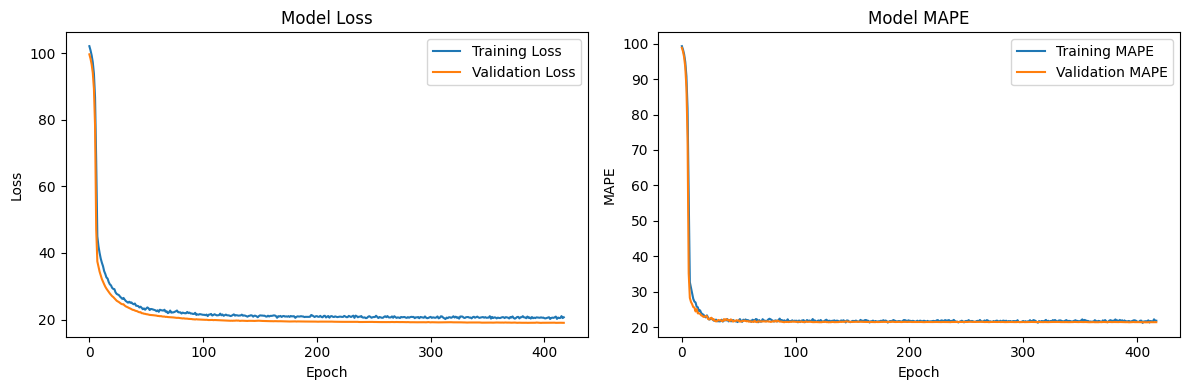

In [7]:

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='Training MAPE')
plt.plot(history.history['val_mape'], label='Validation MAPE')
plt.title('Model MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()

plt.tight_layout()
plt.show()

<class 'numpy.ndarray'>


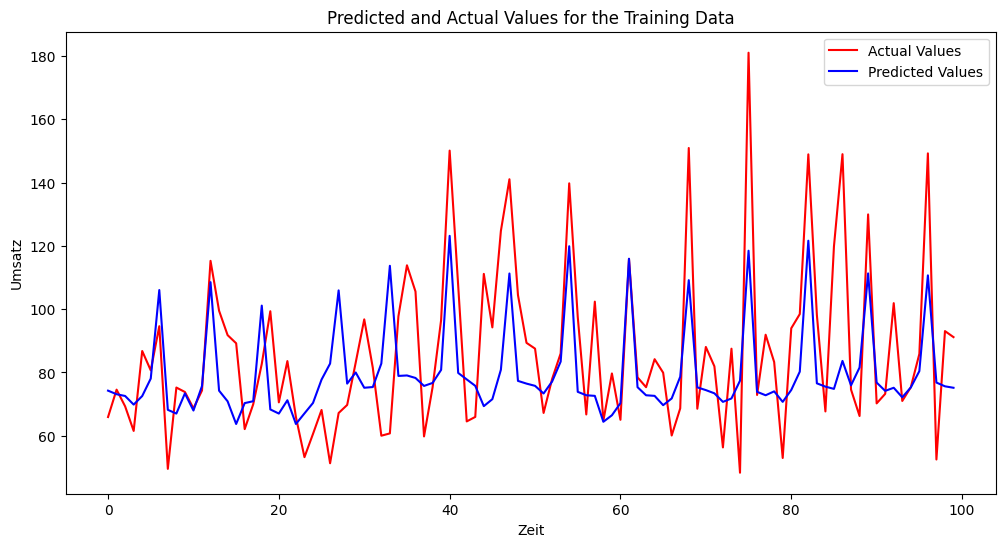

In [13]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()

training_labels = np.array(training_labels).flatten()


# print the type of the predictions
print(type(training_predictions))


# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})


# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')


***VORHERSAGE TESTZEITRAUM***

In [15]:
test_predictions = model.predict(test_features)
#print("Predictions for test data:", test_predictions[:5])  # Display first 5 predictions
# Größe des Arrays anzeigen
print("Größe des Arrays (shape):", test_predictions.shape)
test_predictions = pd.DataFrame(test_predictions)
test_predictions

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Größe des Arrays (shape): (354, 1)


,0
0,77.469780
1,73.486526
2,76.512619
3,81.285751
4,116.162186
...,...
349,75.371140
350,80.917015
351,121.449707
352,77.256958


In [16]:
data_test = pd.read_csv("../../../0_DataPreparation/00_data/data_with_lag/Testdaten_with_lag.csv")
data_test = data_test[data_test["Warengruppe_4"] == 1]
data_test

,id,Datum,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,Temp_Very_Cold_current,Temp_Very_Cold_prev,...,zwischen_den_jahren_next,Number_of_ships_scaled_current,Number_of_ships_scaled_prev,Number_of_ships_scaled_next,Cloud_ok_current,Cloud_ok_prev,Cloud_ok_next,Wind_ok_current,Wind_ok_prev,Wind_ok_next
1065,1808014,2018-08-01,0,0,0,1,0,0,0,0.0,...,0.0,0.0,0.2,0.0,1,0.0,1.0,1,1.0,1.0
1066,1808024,2018-08-02,0,0,0,1,0,0,0,0.0,...,0.0,0.0,0.0,0.0,1,1.0,1.0,1,1.0,1.0
1067,1808034,2018-08-03,0,0,0,1,0,0,0,0.0,...,0.0,0.0,0.0,0.2,1,1.0,1.0,1,1.0,1.0
1068,1808044,2018-08-04,0,0,0,1,0,0,0,0.0,...,0.0,0.2,0.0,0.0,1,1.0,0.0,1,1.0,1.0
1069,1808054,2018-08-05,0,0,0,1,0,0,0,0.0,...,0.0,0.0,0.2,0.0,0,1.0,1.0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,1907264,2019-07-26,0,0,0,1,0,0,0,0.0,...,0.0,0.0,0.2,0.6,1,0.0,1.0,1,1.0,0.0
1415,1907274,2019-07-27,0,0,0,1,0,0,0,0.0,...,0.0,0.6,0.0,0.4,1,1.0,1.0,0,1.0,1.0
1416,1907284,2019-07-28,0,0,0,1,0,0,0,0.0,...,0.0,0.4,0.6,0.2,1,1.0,0.0,1,0.0,1.0
1417,1907294,2019-07-29,0,0,0,1,0,0,0,0.0,...,0.0,0.2,0.4,0.2,0,1.0,0.0,1,1.0,1.0


In [17]:
# Erstelle Ziel csv Datei

predictions_df = pd.DataFrame({
    'id': data_test['id'].values,
    'Umsatz': test_predictions[0].values
}).reset_index(drop=True)

# Save to a CSV file
#output_csv_path = "/workspaces/bakery_sales_prediction/3_Model/02_Franz/V3_lag/Umsatzvorhersage_Konditorei_Hochladeformat.csv"

predictions_df.to_csv('Konditorei_Umsatzvorhersage.csv', index=False)
print(f"CSV Datei erstellt")

CSV Datei erstellt
